In [1]:
!pip install transformers
!apt install swig
# Sentencepieceのインストール
!pip install sentencepiece
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-roberta-base")
tokenizer.do_lower_case = True  # due to some bug of tokenizer config loading

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
!pip install torch
import torch
# GPUが使えれば利用する設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import lightgbm
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import csv
import glob
import re
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

## data shori

In [4]:
mydata = '/export/livedoor' 
#処理をした結果を保存するファイル名 
tsv_fname = "all_text.tsv" 

def remove_brackets(inp):
    output = re.sub(u'[〃-〿]', '',(re.sub('＝|=|※|×|\(|\)|“|”|（|）|／|\[|\]| |　|…|・|：|\n|\t|/|＜|＞|@|＠', '', re.sub(u'[ℊ-⿻]', '', inp)))) #210A ~ 2FFF
    return output

def read_title(f):
    next(f)
    next(f)
    title = next(f)
    title = remove_brackets(title.encode().decode('utf-8'))
    return title[:-1]

def read_para(f):
    p = ''
    while True:
        try:
            para = next(f)
            para = remove_brackets(para.encode().decode('utf-8'))
            p += para
        except StopIteration:
            break
    return p [:-1]

In [5]:
directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/it-life-hack']
target_genre = ["dokujo-tsushin", "it-life-hack"] 
zero_fnames = []
one_fnames = []

if os.path.exists(tsv_fname) == True:
    with open(tsv_fname, "r+") as f:
        f.truncate(0)

for i in range(2):
    for filename in os.listdir(directory[i]):
        if "LICENSE.txt" in filename:
            continue
        f = os.path.join(directory[i], filename)
        #if os.path.isfile(f):
        #    print(f)
        if target_genre[0] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[0], '0', title, para]
                    writer.writerow(row)
            continue
        if target_genre[1] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[1], '1', title, para]
                    writer.writerow(row)
            continue

In [6]:
import pandas as pd
# データの読み込み
df = pd.read_csv("all_text.tsv", 
                 delimiter='\t', header=None, names=['media_name', 'label','title','sentence'])
# データの確認
print(f'データサイズ： {df.shape}')
df.sample(10)

データサイズ： (1740, 4)


,media_name,label,title,sentence
328,dokujo-tsushin,0,意外と身近にあるレアアースを知,昨年、中国がレアアースの輸出規制をして以来、レアアース問題に世間の関心は集まっている。ところ...
639,dokujo-tsushin,0,オトナ女子映画部愛されるより愛す喜びに生きるエディットピアフ愛の讃,女性へのメッセージをいただけますか？愛しなさい若い子には？愛しなさい子供には？愛しなさいラス...
1477,it-life-hack,1,ジメっとした気分を吹き飛ばせ！いまが見ごろ、鎌倉の紫陽花写真の,この季節の代表的な花と言えば紫陽花だ。土壌の状態ph度で花の色が変わり酸性なら青アルカリ性な...
309,dokujo-tsushin,0,昔、不幸の手紙は今やチェーンメー,かつて不幸の手紙なるものがあった。ネットのない時代だったので、葉書にこの手紙を人に送らないと...
341,dokujo-tsushin,0,災害ボランティア体験者が感じたこ,東日本大震災から、約２ヵ月。TVで流れてくる映像やネットから伝わる情報に衝撃を受け、何も手に...
1396,it-life-hack,1,2D動画を3Dに変換！Webから動画ダウンロードもできるソフトのレビューアー募集開,ソーシャルレビューコミュニティzigsowジグソーは、Wondershare社ワンダーシェア...
624,dokujo-tsushin,0,お寿司orステーキ！？デートでは何が食べたい,7歳年上の自営業の男性と見合いをした歩さん29歳。相手は写真より実物のほうが素敵な人だったし...
1038,it-life-hack,1,Windows＆LinuxのデュアルOS！ThinkpadX1Hybrid39より発売開始,1月のCESでアナウンスされ、試作段階とは思えない完成度の高さ、日本発！大和研究所魂で多くの...
385,dokujo-tsushin,0,マスクで顔を隠す独女た,東京渋谷のセンター街でマスク姿の1030代の男女100人にアンケート調査を実施したところ、男...
1702,it-life-hack,1,ダウンロードカードも販売！任天堂によるソフトダウンロード販売の詳細が明らかにデジ,任天堂はいままではパッケージソフトの販売は、ゲーム販売店や大手量販店で販売する方法が主流だっ...


In [7]:
mn = df.media_name.values
labels = df.label.values
titles = df.title.values
sentences = df.sentence.values

## moderu

In [8]:
model_name_s = "csebuetnlp/mT5_multilingual_XLSum"
tokenizer_s = AutoTokenizer.from_pretrained(model_name_s)
model_s = AutoModelForSeq2SeqLM.from_pretrained(model_name_s)

In [9]:
summaries = np.zeros(len(sentences), dtype=object)

In [10]:
for i in range(len(sentences)):
    article_text = sentences[i]
    input_ids = tokenizer_s(
        article_text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=6000
    )["input_ids"]
    output_ids = model_s.generate(
        input_ids=input_ids,
        max_length=1024,
        no_repeat_ngram_size=2,
        num_beams=4
    )[0]
    summary = tokenizer_s.decode(
        output_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )
    summaries[i] = summary
    if i % 10 == 0:
        print(i)  

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730


In [11]:
summas = []

for i in range(df.shape[0]):
    summas.append(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(summaries[i])))

summas = pd.DataFrame(summas)

In [12]:
# 最大単語数の確認
max_len = []
# 1文づつ処理
for summa in summaries:
    # Tokenizeで分割
    token_words = tokenizer.tokenize(summa)
    # 文章数を取得してリストへ格納
    max_len.append(len(token_words))
# 最大の値を確認
print('最大単語数: ', max(max_len))
print('上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数')

最大単語数:  68
上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数


In [27]:
input_ids = []
attention_masks = []

# 1文づつ処理
for summa in summaries:
    encoded_dict = tokenizer.encode_plus(
                        summa,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = 50,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    
    # https://qiita.com/YuiKasuga/items/343309257da1798c1b63

    # 単語IDを取得    
    input_ids.append(encoded_dict['input_ids'])

    # Attention　maskの取得
    attention_masks.append(encoded_dict['attention_mask'])

# リストに入ったtensorを縦方向（dim=0）へ結合
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# tenosor型に変換
labels = torch.tensor(labels)

# 確認
print('Original: ', summaries[0])
print('Token IDs:', input_ids[0])

Original:  思いがけないことがある人間は、未来を教えてくれることがある。
Token IDs: tensor([    9,  2969,    12, 18143,  1272,   858,    11,     7,  3638, 15718,
        17379,  1272,     8,     2,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3])


In [16]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# データセットクラスの作成
dataset = TensorDataset(input_ids, attention_masks, labels)

# 90%地点のIDを取得
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# データセットを分割
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('訓練データ数：{}'.format(train_size))
print('検証データ数:　{} '.format(val_size))

# データローダーの作成
batch_size = 32

# 訓練データローダー
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
        )

# 検証データローダー
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )

訓練データ数：1566
検証データ数:　174 


In [17]:
from transformers import BertForSequenceClassification,AdamW,BertConfig

# BertForSequenceClassification 学習済みモデルのロード
model = BertForSequenceClassification.from_pretrained(
    "cl-tohoku/bert-base-japanese-whole-word-masking", # 日本語Pre trainedモデルの指定
    num_labels = 2, # ラベル数（今回はBinayなので2、数値を増やせばマルチラベルも対応可）
    output_attentions = False, # アテンションベクトルを出力するか
    output_hidden_states = False, # 隠れ層を出力するか
)

# モデルをGPUへ転送
model.cuda()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [18]:
# 最適化手法の設定
optimizer = AdamW(model.parameters(), lr=2e-5)

# 訓練パートの定義
def train(model):
    model.train() # 訓練モードで実行
    train_loss = 0
    for batch in train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    return train_loss

# テストパートの定義
def validation(model):
    model.eval()# 訓練モードをオフ
    val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            val_loss += loss.item()
    return val_loss

In [19]:
# 学習の実行
max_epoch = 10
train_loss_ = []
test_loss_ = []

for epoch in range(max_epoch):
    train_ = train(model)
    test_ = train(model)
    train_loss_.append(train_)
    test_loss_.append(test_)

In [1]:
#correct = 0
test_accuracy = 0

# 検証方法の確認（1バッチ分で計算ロジックに確認）

model.eval()# 訓練モードをオフ
for batch in validation_dataloader:
    #print(batch)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    #print(len(b_labels))
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        preds = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        test_accuracy += (torch.argmax(preds[0]) == b_labels).sum().item() / len(b_labels)

        #print(preds[0])
        #print(b_labels)

print(test_accuracy)


NameError: name 'model' is not defined

In [21]:
# 予測結果の確認
print(f'出力:{preds}')

出力:SequenceClassifierOutput(loss=None, logits=tensor([[ 1.2220, -1.5854],
        [ 1.2220, -1.5854],
        [ 4.9110, -4.4560],
        [-5.0631,  4.7583],
        [-4.9945,  4.5908],
        [-5.1711,  4.8990],
        [-5.1092,  4.8347],
        [-5.0992,  4.8399],
        [-5.1289,  4.7986],
        [-5.1814,  4.7742],
        [-4.7300,  4.3734],
        [ 4.8924, -4.2957],
        [ 4.8416, -4.4289],
        [-5.0318,  4.6252]], device='cuda:0'), hidden_states=None, attentions=None)


In [23]:
# 比較しやすい様にpd.dataframeへ整形
import numpy as np
# pd.dataframeへ変換（GPUに乗っているTensorはgpu->cpu->numpy->dataframeと変換）
logits_df = pd.DataFrame(preds[0].cpu().numpy(), columns=['logit_0', 'logit_1'])
## np.argmaxで大き方の値を取得
pred_df = pd.DataFrame(np.argmax(preds[0].cpu().numpy(), axis=1), columns=['pred_label'])
label_df = pd.DataFrame(b_labels.cpu().numpy(), columns=['true_label'])
accuracy_df = pd.concat([logits_df, pred_df, label_df], axis=1)
accuracy_df.head()

,logit_0,logit_1,pred_label,true_label
0,1.221978,-1.585371,0,0
1,1.221978,-1.585371,0,0
2,4.910961,-4.456045,0,0
3,-5.063131,4.758265,1,1
4,-4.994461,4.590831,1,1


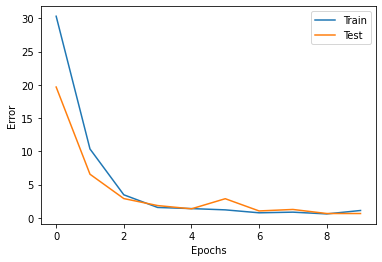

In [24]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_)), train_loss_, label="Train")
plt.plot(range(len(test_loss_)), test_loss_, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()  # ラベルがあるときは、きちんとplt.show()を呼び出すこと

In [115]:
import csv

summary_set = "summary_set_dokujo_it.tsv" 

if os.path.exists(summary_set) == True:
    with open(summary_set, "r+") as s:
        s.truncate(0)
        
# nijigen hairetsu ni suru
sum_set = summaries.reshape(-1, 1)

with open(summary_set, mode='w', newline='', encoding='utf-8') as ss:
    w = csv.writer(ss, delimiter='\t')
    w.writerows(sum_set)

In [112]:
sum_set.shape, summaries.shape

((1740, 1), (1740,))

In [114]:
col_names = ['c{0:02d}'.format(i) for i in range(1)]
# データの読み込み
s_s = pd.read_csv("summary_set_dokujo_it.tsv", 
                 delimiter='\t', names=col_names)
# データの確認
print(f'データサイズ： {s_s.shape}')
s_s.sample(10)

データサイズ： (1740, 1)


,c00
1738,新しい一年が近づき、新しい人との対人関係を築きたい。
1690,今年7月27日から今日8月12日までロンドンオリンピック関連のロゴに変化していたGoogle記事。
812,クリスマスは、思いが叶う新しいパワースポットが、ネットやインターネットで広まりを見せている。
864,いわゆる「夏日」は夏らしい。特に暑く乾燥した服装で、特に露出したパンツを身に着ける女性は特に...
343,真夏が到来するなか、夏らしい服装を履く人が増えている。
285,中途半端な元美人にとって、恋に落ちるのはストレスではない。
500,思いがけない話、理解の深まる話。
282,人は言う。現代は憎しみと欲だけと。
1157,日本の金環日食が25年ぶりに行われた。日本の複数メディアが伝えた。
1674,知っ得!虎の巻 は、日本のソーシャルメディアで最も人気を集めている。特に人気なのがTumbl...
